# 0. Import Libraries

In [4]:
# Import necessary libraries for data manipulation, visualization, and clustering

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

from datetime import timedelta

# 1. Import Data

In [12]:
# Load the dataset from a CSV file


df = pd.read_csv('Datasets/ECommerce_Retail_Orders.csv')

# Display the first 10 rows to confirm data availability

df.head(10)

,OrderID,ProductID,Quantity,UnitPrice,InvoiceDate,CustomerID,Country
0,95822412,P58051,5.0,20.01,2024-01-06,cust8269,United States
1,24942603,P70137,1.0,28.71,2023-12-08,cust8456,United States
2,13356886,P54746,7.0,6.52,2024-09-07,cust5645,United States
3,46913810,P85324,3.0,39.35,2024-10-03,cust3447,United States
4,42868828,P56891,5.0,43.17,2022-12-05,cust3360,United States
5,39958838,P53569,2.0,3.78,2023-03-02,cust1307,United States
6,28728463,P59659,4.0,2.66,2023-07-18,cust3381,United States
7,23756669,P70606,4.0,NaN,2024-06-30,cust4688,United States
8,83197857,P51114,7.0,26.05,2023-04-26,cust6394,United States
9,21668732,P82331,2.0,1.80,2023-05-26,cust7884,United States


# 2. Data Exploration

In [7]:
# Show columns, data types, and nulls to prepare hygiene activities

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143273 entries, 0 to 143272
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   OrderID      143273 non-null  int64  
 1   ProductID    143273 non-null  object 
 2   Quantity     136110 non-null  float64
 3   UnitPrice    136110 non-null  float64
 4   InvoiceDate  143273 non-null  object 
 5   CustomerID   136110 non-null  object 
 6   Country      143273 non-null  object 
dtypes: float64(2), int64(1), object(4)
memory usage: 7.7+ MB


In [8]:
# Show descriptive statistics for quantitative columns

df.describe()

,OrderID,Quantity,UnitPrice
count,1.432730e+05,136110.000000,136110.000000
mean,5.506636e+07,5.504842,25.476766
std,2.602830e+07,2.872986,14.119850
min,1.000127e+07,1.000000,1.000000
25%,3.239540e+07,3.000000,13.290000
50%,5.516044e+07,5.000000,25.500000
75%,7.753406e+07,8.000000,37.700000
max,9.999995e+07,10.000000,50.000000


In [9]:
# Show descriptive statistics for object columns

df.describe(include='O')

,ProductID,InvoiceDate,CustomerID,Country
count,143273,143273,136110,143273
unique,37221,731,9000,1
top,P88291,2023-08-09,cust6684,United States
freq,16,249,32,143273


In [10]:
# Check for quantities less than zero to potentially exclude rows

df[df["Quantity"] < 0].head(10)

,OrderID,ProductID,Quantity,UnitPrice,InvoiceDate,CustomerID,Country


In [11]:
# Check for prices less than zero to potential exclude rows

df[df["UnitPrice"] < 0].head(10)

,OrderID,ProductID,Quantity,UnitPrice,InvoiceDate,CustomerID,Country


In [18]:
# Check for Order IDs that do not match the eight-digit pattern

df["OrderID"] = df["OrderID"].astype("str")
df[df["OrderID"].str.match("^\\d{8}$") == False]

,OrderID,ProductID,Quantity,UnitPrice,InvoiceDate,CustomerID,Country


In [13]:
# Check for Order IDs that include alphabetical characters

df["OrderID"].str.replace("[0-9]","",regex=True).unique()

array([''], dtype=object)

In [14]:
# Check for Product IDs that include alphabetical characters ('P' is the prefix for every Product ID)

df["ProductID"].str.replace("[0-9]","",regex=True).unique()

array(['P'], dtype=object)

In [15]:
# Check date range for Invoice Dates

df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

print(df["InvoiceDate"].min())
print(df["InvoiceDate"].max())

2022-10-29 00:00:00
2024-10-28 00:00:00


# 3. Data Cleansing

In [17]:
# Filter dates to one year, rolling, based on latest entry in the dataset

max_invoicedate = df["InvoiceDate"].max()

one_year_invoicedate = max_invoicedate - timedelta(days=365)

df_last_year = df[df["InvoiceDate"] >= one_year_invoicedate]



In [18]:
cleaned_df = df_last_year.copy()

In [19]:
# Drop rows with missing values for cleaner clustering

cleaned_df.dropna(subset=["Quantity"], inplace=True)

In [20]:
# Include only rows with a price available

cleaned_df = cleaned_df[cleaned_df["UnitPrice"] != 0.00]

In [21]:
# Show descriptive statistics for quantitative columns, compared to original dataset

cleaned_df.describe()

,Quantity,UnitPrice,InvoiceDate
count,68571.000000,65148.00000,68571
mean,5.531945,25.49914,2024-04-29 08:33:23.412521472
min,1.000000,1.00000,2023-10-29 00:00:00
25%,3.000000,13.29000,2024-01-29 00:00:00
50%,6.000000,25.51000,2024-04-29 00:00:00
75%,8.000000,37.77000,2024-07-30 00:00:00
max,10.000000,50.00000,2024-10-28 00:00:00
std,2.874175,14.14824,NaN


In [22]:
# Confirm that the cleaned data is sufficient for modeling

len(cleaned_df)/len(df_last_year)

0.9496842280206083

The critical columns are related to order volume and dates, as well as the customer identifier for each order. The analysis will focus on frequency, recency, and total annual value (TAV) by customer. 

Supplementary columns that are non-critical but provide additional information are the product identifiers and customer's country. 

The dataset was filtered from two years of Invoice Dates down to one year of data. This allows for consistency in duration scope for rolling analysis and tuning. For the initial analysis, Invoice Dates range from 10/26/2023 to 10/25/2024.

After removing rows with null quantities or prices less than zero, 95% of data remains. 

# 4. Feature Engineering

In [25]:
# Calculate Sales Total to find monetary order values

cleaned_df["SalesTotal"] = cleaned_df["Quantity"] * cleaned_df["UnitPrice"]
cleaned_df.head(10)

,OrderID,ProductID,Quantity,UnitPrice,InvoiceDate,CustomerID,Country,SalesTotal
0,95822412,P58051,5.0,20.01,2024-01-06,cust8269,United States,100.05
1,24942603,P70137,1.0,28.71,2023-12-08,cust8456,United States,28.71
2,13356886,P54746,7.0,6.52,2024-09-07,cust5645,United States,45.64
3,46913810,P85324,3.0,39.35,2024-10-03,cust3447,United States,118.05
7,23756669,P70606,4.0,NaN,2024-06-30,cust4688,United States,NaN
10,89254563,P85093,5.0,11.53,2023-11-22,cust9747,United States,57.65
13,13999315,P78788,2.0,30.58,2024-09-29,cust7977,United States,61.16
15,39345092,P65616,2.0,48.79,2024-06-16,cust6756,United States,97.58
16,41227216,P71364,7.0,27.91,2024-04-26,cust1089,United States,195.37
17,77827638,P50314,10.0,39.24,2024-05-15,cust8963,United States,392.40


In [26]:
# Create a new dataframe that holds the three features for clustering: TAV, Frequency, and Last Invoice Date (to be replaced with Recency)

aggregated_df = cleaned_df.groupby(by="CustomerID", as_index=False).agg(
    TAV = ("SalesTotal", "sum"),
    Frequency = ("OrderID", "nunique"),
    LastInvoiceDate = ("InvoiceDate", "max")
)

aggregated_df.head(10)

,CustomerID,TAV,Frequency,LastInvoiceDate
0,cust1000,1840.87,9,2024-10-27
1,cust1001,1009.89,6,2024-09-16
2,cust1002,782.89,5,2024-09-15
3,cust1003,574.49,5,2024-09-06
4,cust1004,265.55,4,2024-09-29
5,cust1005,1254.24,10,2024-09-21
6,cust1006,1295.17,7,2024-09-15
7,cust1007,485.42,3,2024-08-26
8,cust1008,1101.60,5,2024-10-14
9,cust1009,1111.69,6,2024-10-12


In [27]:
# Set Recency in place of Last Invoice Date

max_invoice_date = aggregated_df["LastInvoiceDate"].max()

aggregated_df["Recency"] = (max_invoice_date - aggregated_df["LastInvoiceDate"]).dt.days

aggregated_df.head(10)

,CustomerID,TAV,Frequency,LastInvoiceDate,Recency
0,cust1000,1840.87,9,2024-10-27,1
1,cust1001,1009.89,6,2024-09-16,42
2,cust1002,782.89,5,2024-09-15,43
3,cust1003,574.49,5,2024-09-06,52
4,cust1004,265.55,4,2024-09-29,29
5,cust1005,1254.24,10,2024-09-21,37
6,cust1006,1295.17,7,2024-09-15,43
7,cust1007,485.42,3,2024-08-26,63
8,cust1008,1101.60,5,2024-10-14,14
9,cust1009,1111.69,6,2024-10-12,16


In [28]:
# Set color palette for plots and charts of feature comparison

feature_colors = {'TAV': '#334c69',
                  'Frequency': '#4b786f',
                  'Recency': '#73a073'}

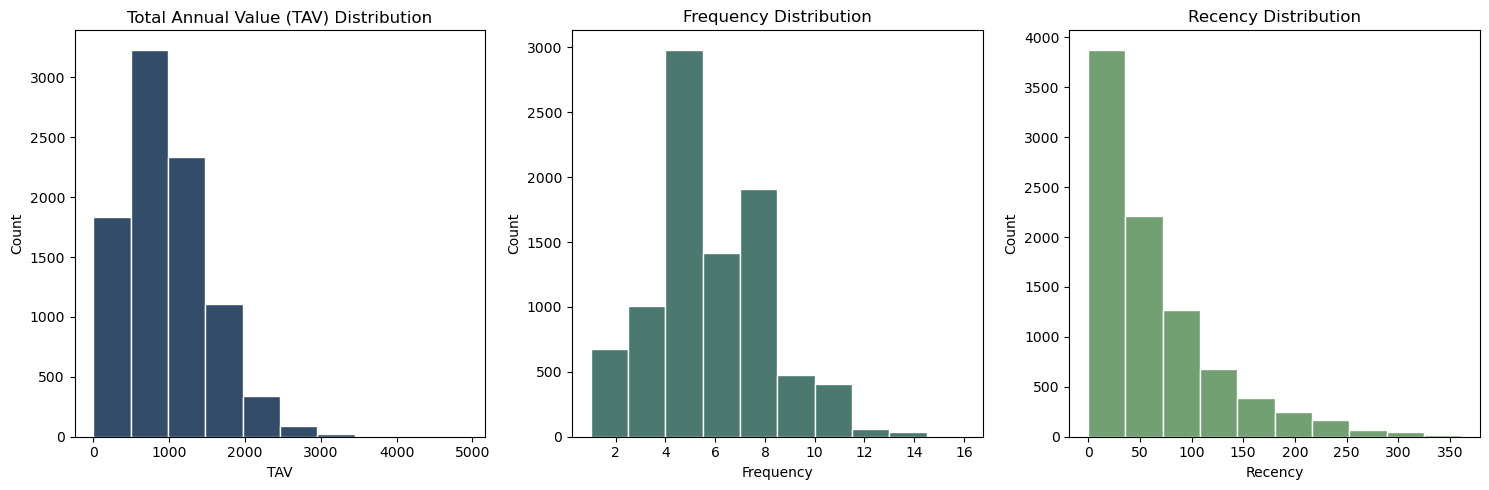

In [29]:
# Plot histograms to understand distributions (and potential skewness of the cleaned data

plt.figure(figsize=(15,5))

plt.subplot(1, 3, 1)
plt.hist(aggregated_df['TAV'], bins=10, color=feature_colors['TAV'], edgecolor='white')
plt.title('Total Annual Value (TAV) Distribution')
plt.xlabel('TAV')
plt.ylabel('Count')

plt.subplot(1, 3, 2)
plt.hist(aggregated_df['Frequency'], bins=10, color=feature_colors['Frequency'], edgecolor='white')
plt.title('Frequency Distribution')
plt.xlabel('Frequency')
plt.ylabel('Count')

plt.subplot(1, 3, 3)
plt.hist(aggregated_df['Recency'], bins=10, color=feature_colors['Recency'], edgecolor='white')
plt.title('Recency Distribution')
plt.xlabel('Recency')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

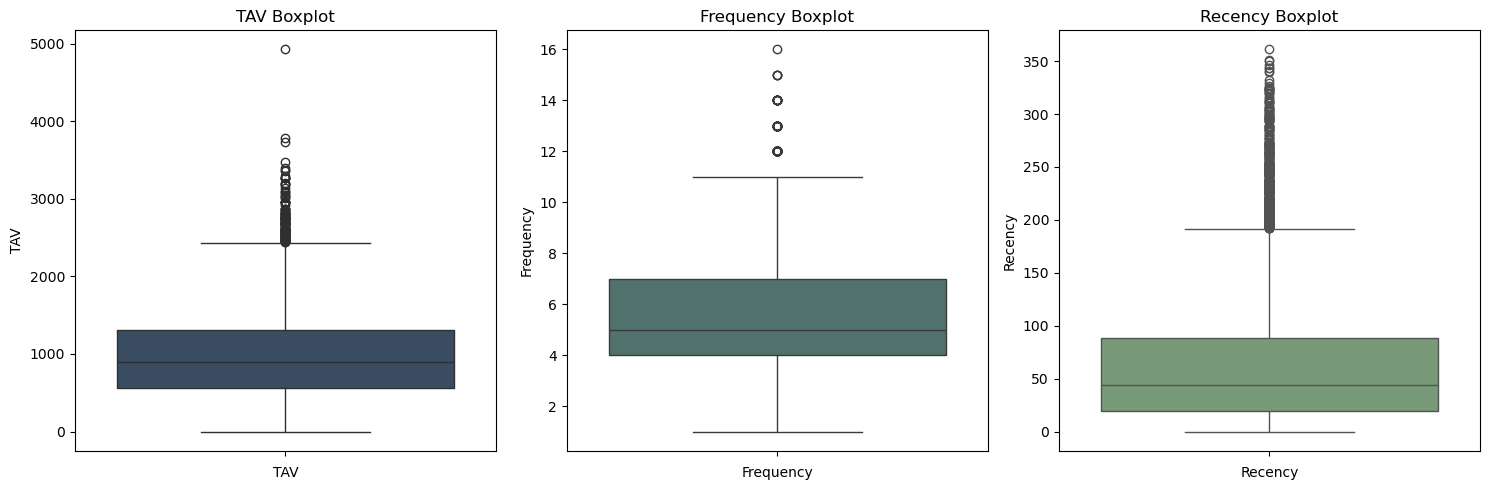

In [30]:
# Plot boxplots to understand outliers within the cleaned dataset

plt.figure(figsize=(15,5))

plt.subplot(1, 3, 1)
sns.boxplot(data=aggregated_df['TAV'], color=feature_colors['TAV'])
plt.title('TAV Boxplot')
plt.xlabel('TAV')


plt.subplot(1, 3, 2)
sns.boxplot(data=aggregated_df['Frequency'], color=feature_colors['Frequency'])
plt.title('Frequency Boxplot')
plt.xlabel('Frequency')


plt.subplot(1, 3, 3)
sns.boxplot(data=aggregated_df['Recency'], color=feature_colors['Recency'])
plt.title('Recency Boxplot')
plt.xlabel('Recency')

plt.tight_layout()
plt.show()

In [31]:
# Segregate TAV outliers for later modeling

tav_q1 = aggregated_df["TAV"].quantile(0.25)
tav_q3 = aggregated_df["TAV"].quantile(0.75)
tav_iqr = tav_q3 - tav_q1

tav_outliers_df = aggregated_df[(aggregated_df["TAV"] > ( tav_q3 + 1.5 * tav_iqr)) | 
(aggregated_df["TAV"] < ( tav_q3 - 1.5 * tav_iqr))].copy()

In [32]:
# Segregate Frequency outliers for later modeling

frequency_q1 = aggregated_df["Frequency"].quantile(0.25)
frequency_q3 = aggregated_df["Frequency"].quantile(0.75)
frequency_iqr = frequency_q3 - frequency_q1

frequency_outliers_df = aggregated_df[(aggregated_df["Frequency"] > (frequency_q3 + 1.5 * frequency_iqr)) | 
(aggregated_df["Frequency"] < (frequency_q1 - 1.5 * frequency_iqr))].copy() 

In [33]:
# Segregate Recency outliers for later modeling

recency_q1 = aggregated_df["Recency"].quantile(0.25)
recency_q3 = aggregated_df["Recency"].quantile(0.75)
recency_iqr = recency_q3 - recency_q1

recency_outliers_df = aggregated_df[(aggregated_df["Recency"] > (recency_q3 + 1.5 * recency_iqr)) | 
(aggregated_df["Recency"] < (recency_q1 - 1.5 * recency_iqr))].copy() 

In [34]:
# Exclude feature (TAV, Frequency, and Recency) outliers

non_outliers_df = aggregated_df[(~aggregated_df.index.isin(tav_outliers_df.index)) & (~aggregated_df.index.isin(frequency_outliers_df.index)) & (~aggregated_df.index.isin(recency_outliers_df.index))]

non_outliers_df.describe()

,TAV,Frequency,LastInvoiceDate,Recency
count,8058.000000,8058.000000,8058,8058.000000
mean,987.022779,5.712087,2024-09-04 09:46:30.469098752,53.592703
min,179.840000,1.000000,2024-04-20 00:00:00,0.000000
25%,606.745000,4.000000,2024-08-10 00:00:00,17.000000
50%,923.430000,6.000000,2024-09-17 00:00:00,41.000000
75%,1312.080000,7.000000,2024-10-11 00:00:00,79.000000
max,2435.850000,11.000000,2024-10-28 00:00:00,191.000000
std,484.106559,2.053161,NaN,45.038934


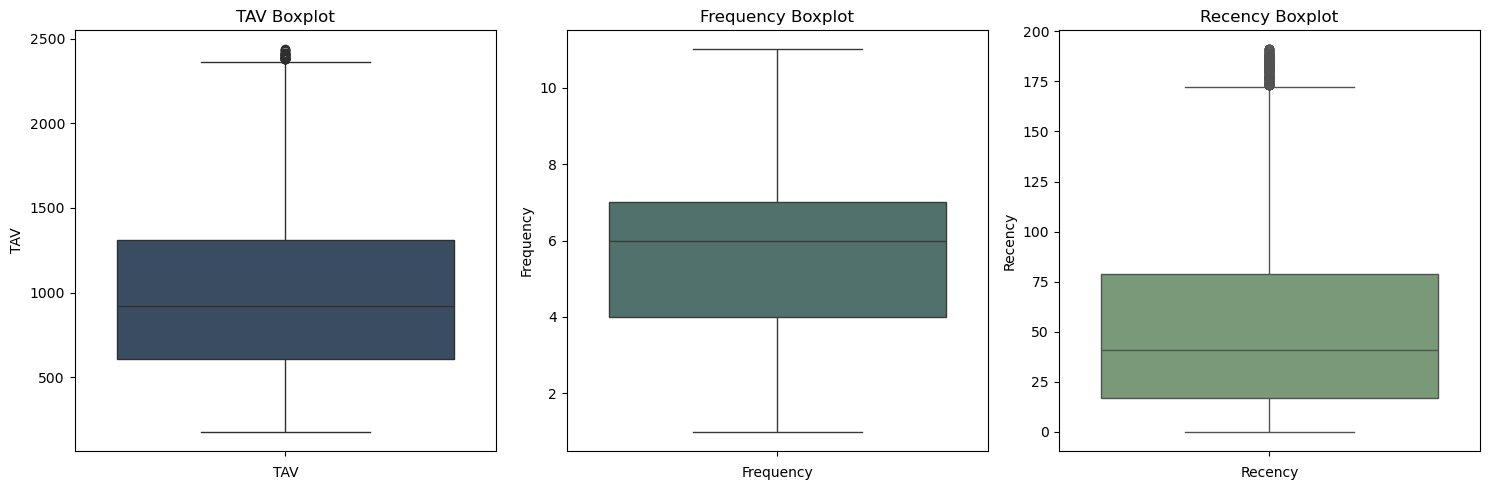

In [35]:
# Re-plot boxplots, without outliers, to understand new ranges and skewness

plt.figure(figsize=(15,5))

plt.subplot(1, 3, 1)
sns.boxplot(data=non_outliers_df['TAV'], color=feature_colors['TAV'])
plt.title('TAV Boxplot')
plt.xlabel('TAV')


plt.subplot(1, 3, 2)
sns.boxplot(data=non_outliers_df['Frequency'], color=feature_colors['Frequency'])
plt.title('Frequency Boxplot')
plt.xlabel('Frequency')


plt.subplot(1, 3, 3)
sns.boxplot(data=non_outliers_df['Recency'], color=feature_colors['Recency'])
plt.title('Recency Boxplot')
plt.xlabel('Recency')

plt.tight_layout()
plt.show()

In [36]:
# Confirm that the cleaned data is sufficient for modeling, considering outliers removed

len(non_outliers_df)/len(aggregated_df)

0.8979273456652552

After removing outliers from our aggregated dataset for modeling, 89.8% remains.

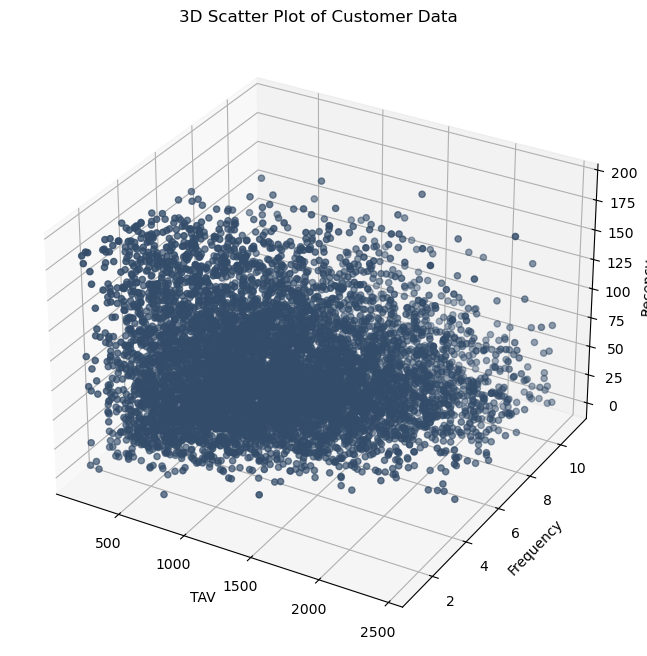

In [38]:
# Plot initial scatter based on the three features

fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(projection="3d")

scatter = ax.scatter(non_outliers_df["TAV"], non_outliers_df["Frequency"], non_outliers_df["Recency"], color='#334c69')

ax.set_xlabel('TAV')
ax.set_ylabel('Frequency')
ax.set_zlabel('Recency')

ax.set_title('3D Scatter Plot of Customer Data')

plt.show()

In [39]:
# Scale the three features to align distancing measurements

scaler = StandardScaler()

scaled_data = scaler.fit_transform(non_outliers_df[["TAV", "Frequency", "Recency"]])

scaled_data

array([[ 1.76386829,  1.60148993, -1.16778889],
       [ 0.04723886,  0.14023766, -0.2574089 ],
       [-0.42169527, -0.34684643, -0.23520451],
       ...,
       [ 0.54891574,  1.60148993,  0.60856232],
       [ 0.5064018 ,  0.14023766, -0.34622646],
       [ 0.32118315, -0.83393051,  2.42932231]])

In [40]:
# Show scaled data for the three features

scaled_data_df = pd.DataFrame(scaled_data, index=non_outliers_df.index, columns=("TAV", "Frequency", "Recency"))

scaled_data_df

,TAV,Frequency,Recency
0,1.763868,1.601490,-1.167789
1,0.047239,0.140238,-0.257409
2,-0.421695,-0.346846,-0.235205
3,-0.852206,-0.346846,-0.035365
4,-1.490411,-0.833931,-0.546066
...,...,...,...
8969,-1.157219,-1.321015,-0.301818
8970,-1.034553,0.627322,0.652971
8971,0.548916,1.601490,0.608562
8972,0.506402,0.140238,-0.346226


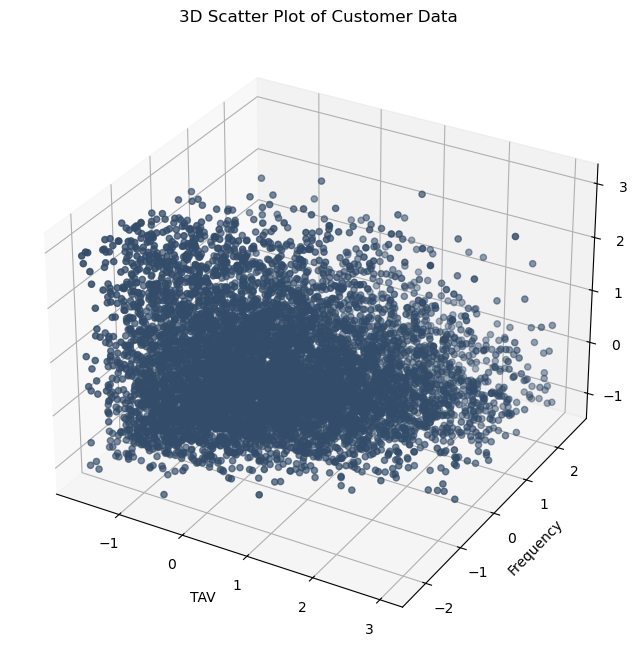

In [41]:
# Re-plot datapoints with scaled features

fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(projection="3d")

scatter = ax.scatter(scaled_data_df["TAV"], scaled_data_df["Frequency"], scaled_data_df["Recency"], color='#334c69')

ax.set_xlabel('TAV')
ax.set_ylabel('Frequency')
ax.set_zlabel('Recency')

ax.set_title('3D Scatter Plot of Customer Data')

plt.show()

# 5. Model Training

### Non-Outlier Analysis

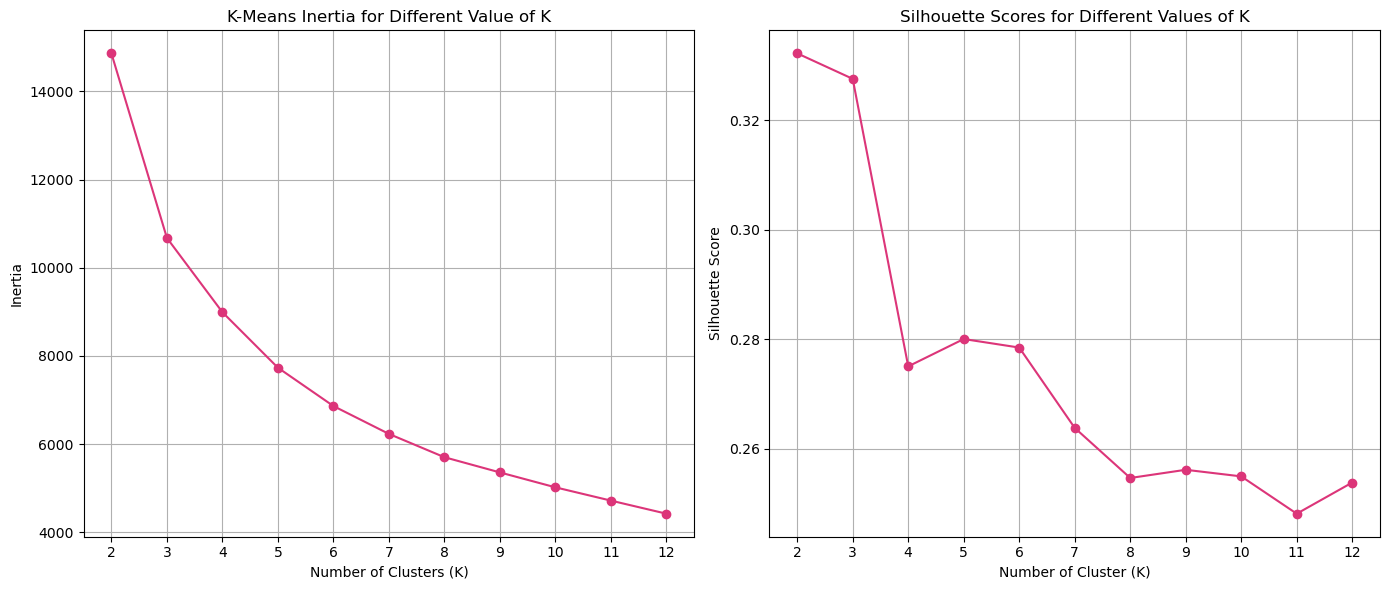

In [44]:
# Initialize the K-Means clustering model

max_k = 12

inertia = []
silhouette_scores = []
k_values = range(2, max_k+1)

for k in k_values:
    
    kmeans = KMeans(n_clusters=k, random_state=42, max_iter=1000)
    cluster_labels = kmeans.fit_predict(scaled_data_df)
    sil_score = silhouette_score(scaled_data_df, cluster_labels)
    silhouette_scores.append(sil_score)
    kmeans.fit_predict(scaled_data_df)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(14,6))

plt.subplot(1, 2, 1)
plt.plot(k_values, inertia, marker='o', color='#dc3579')
plt.title('K-Means Inertia for Different Value of K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.xticks(k_values)
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(k_values, silhouette_scores, marker='o', color='#dc3579')
plt.title('Silhouette Scores for Different Values of K')
plt.xlabel('Number of Cluster (K)')
plt.ylabel('Silhouette Score')
plt.xticks(k_values)
plt.grid(True)

plt.tight_layout()
plt.show()
# Fit the model to the selected features

In [45]:
# Initialize the K-Means clustering model
# Set the number of clusters (k) based on the Elbow Method and silhouette score graph, as show above

kmeans = KMeans(n_clusters=4, random_state=42, max_iter=1000)

cluster_labels = kmeans.fit_predict(scaled_data_df)

cluster_labels

array([1, 2, 0, ..., 1, 2, 3])

In [46]:
# Display the first 10 rows of the dataset, showing the initial Cluster for each customer

non_outliers_df["Cluster"] = cluster_labels

non_outliers_df.head(10)

C:\Users\halli\AppData\Local\Temp\ipykernel_13940\2546864245.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_outliers_df["Cluster"] = cluster_labels


,CustomerID,TAV,Frequency,LastInvoiceDate,Recency,Cluster
0,cust1000,1840.87,9,2024-10-27,1,1
1,cust1001,1009.89,6,2024-09-16,42,2
2,cust1002,782.89,5,2024-09-15,43,0
3,cust1003,574.49,5,2024-09-06,52,0
4,cust1004,265.55,4,2024-09-29,29,0
5,cust1005,1254.24,10,2024-09-21,37,1
6,cust1006,1295.17,7,2024-09-15,43,2
7,cust1007,485.42,3,2024-08-26,63,0
8,cust1008,1101.60,5,2024-10-14,14,2
9,cust1009,1111.69,6,2024-10-12,16,2


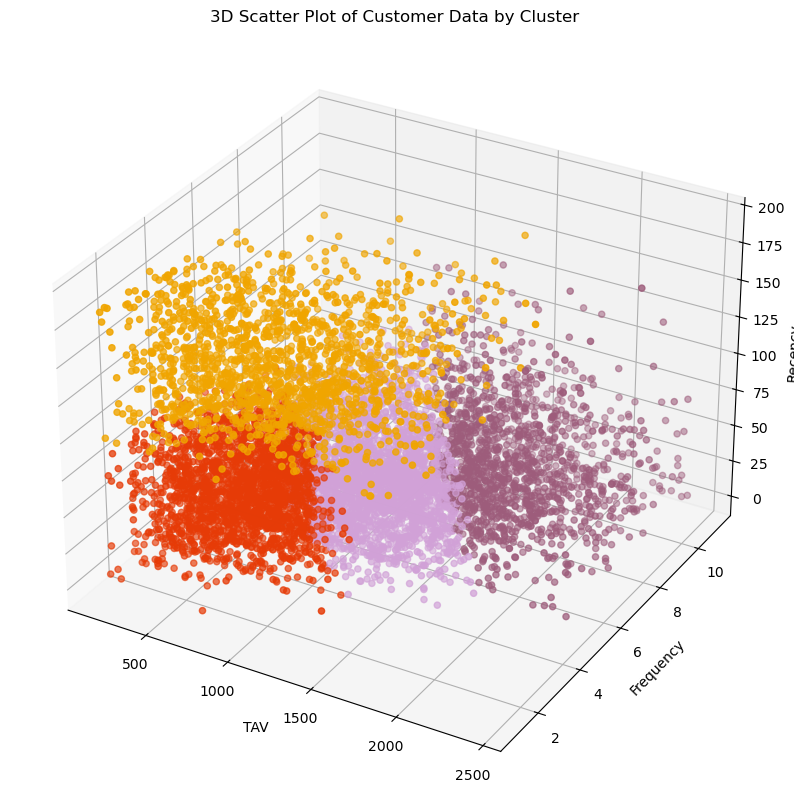

In [47]:
# Plot clusters

cluster_colors = {0: '#e63b07',
                  1: '#9d5c7b',
                  2: '#d1a1d7',
                  3: '#f0a500'}

colors = non_outliers_df['Cluster'].map(cluster_colors)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')

scatter = ax.scatter(non_outliers_df['TAV'],
                     non_outliers_df['Frequency'],
                     non_outliers_df['Recency'],
                     c=colors,
                     marker='o')

ax.set_xlabel('TAV')
ax.set_ylabel('Frequency')
ax.set_zlabel('Recency')

ax.set_title('3D Scatter Plot of Customer Data by Cluster')

plt.show()

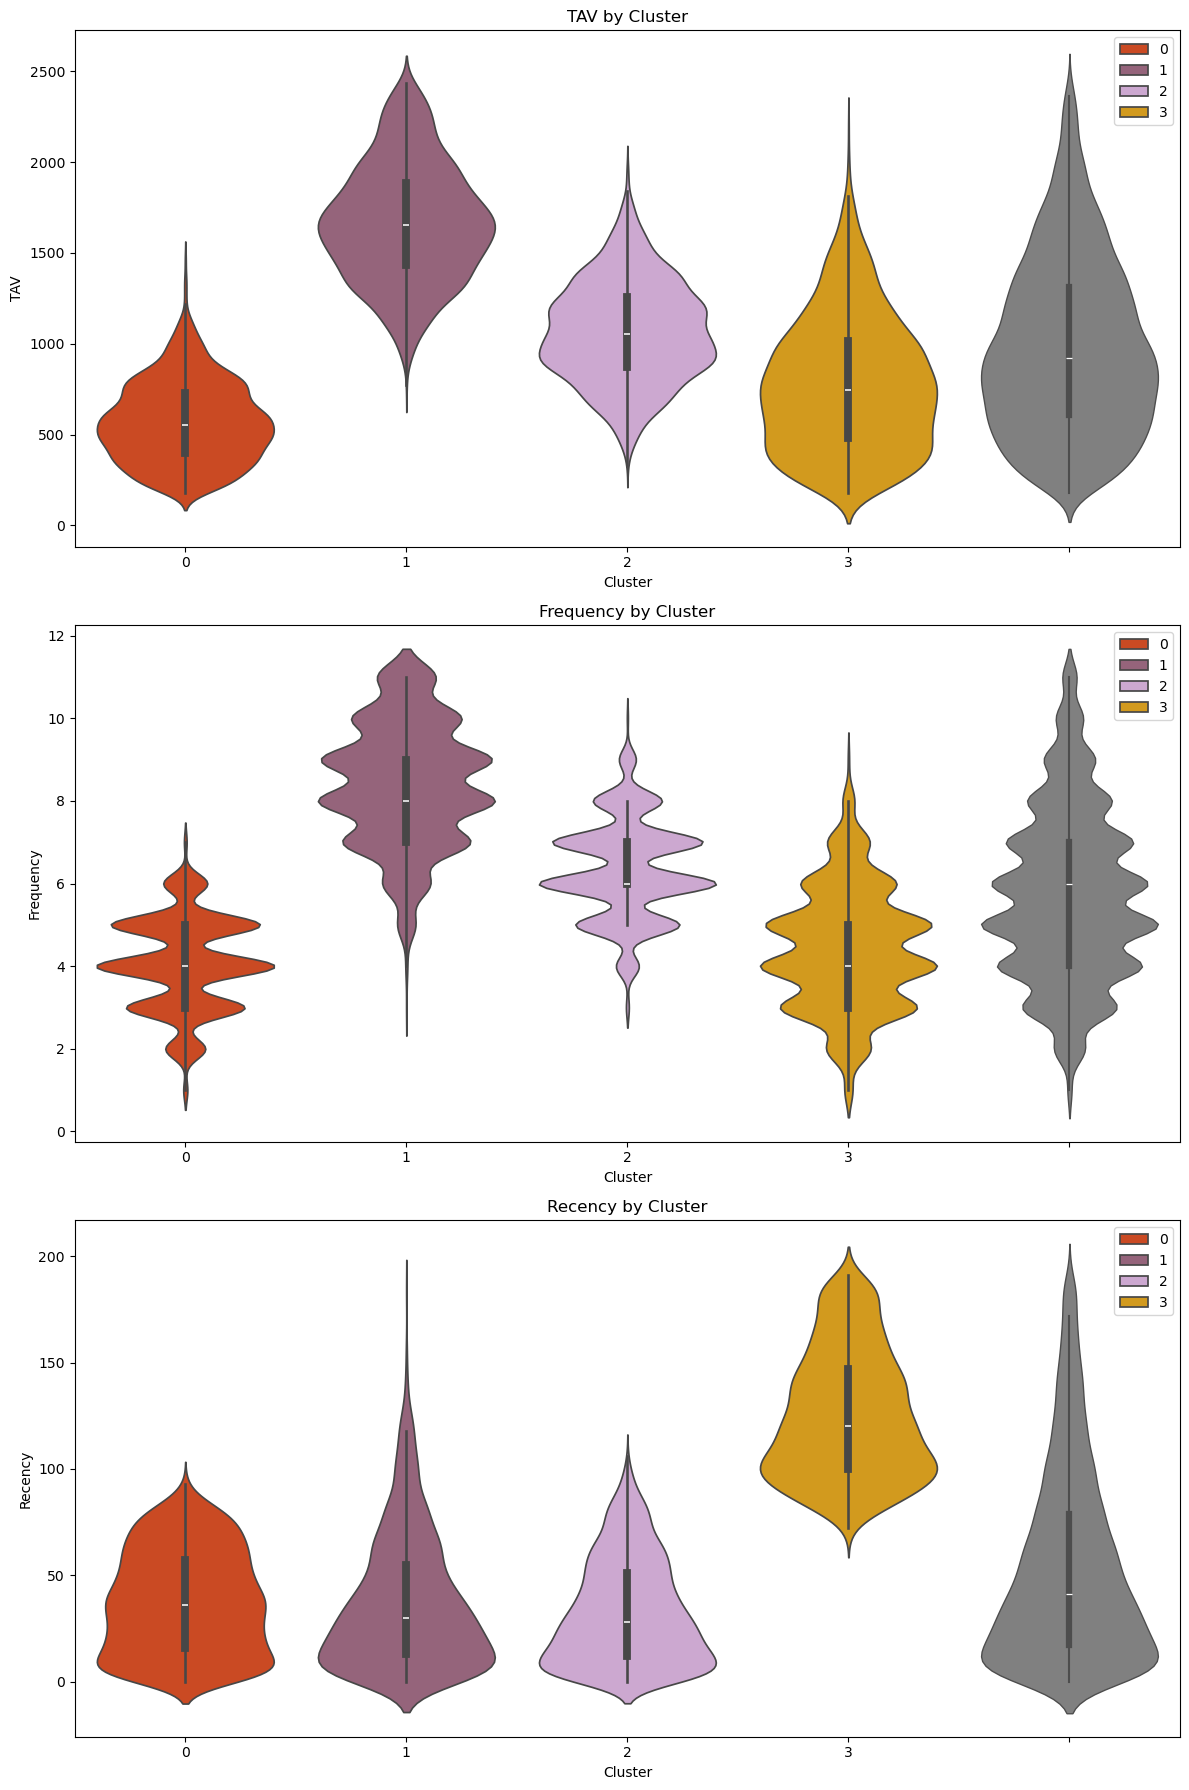

In [48]:
# Plot clusters to compare across each of the three features

plt.figure(figsize=(12, 18))

plt.subplot(3, 1, 1)
sns.violinplot(x=non_outliers_df['Cluster'], y=non_outliers_df['TAV'], palette=cluster_colors, hue=non_outliers_df["Cluster"])
sns.violinplot(y=non_outliers_df['TAV'], color='gray',linewidth=1.0)
plt.title('TAV by Cluster')
plt.ylabel('TAV')

plt.subplot(3, 1, 2)
sns.violinplot(x=non_outliers_df['Cluster'], y=non_outliers_df['Frequency'], palette=cluster_colors, hue=non_outliers_df["Cluster"])
sns.violinplot(y=non_outliers_df['Frequency'], color='gray',linewidth=1.0)
plt.title('Frequency by Cluster')
plt.ylabel('Frequency')

plt.subplot(3, 1, 3)
sns.violinplot(x=non_outliers_df['Cluster'], y=non_outliers_df['Recency'], palette=cluster_colors, hue=non_outliers_df["Cluster"])
sns.violinplot(y=non_outliers_df['Recency'], color='gray',linewidth=1.0)
plt.title('Recency by Cluster')
plt.ylabel('Recency')

plt.tight_layout()
plt.show()

### Outlier Analysis

In [50]:
# Set the clusters (k) based on the overlap of the three features

overlap_indices_all = tav_outliers_df.index.intersection(frequency_outliers_df.index).intersection(recency_outliers_df.index)

tav_only_outliers = tav_outliers_df.drop(overlap_indices_all)
frequency_only_outliers = frequency_outliers_df.drop(overlap_indices_all)
recency_only_outliers = recency_outliers_df.drop(overlap_indices_all)

overlap_tav_frequency_only = tav_outliers_df.index.intersection(frequency_outliers_df.index).difference(recency_outliers_df.index)
overlap_tav_recency_only = tav_outliers_df.index.intersection(recency_outliers_df.index).difference(frequency_outliers_df.index)
overlap_frequency_recency_only = frequency_outliers_df.index.intersection(recency_outliers_df.index).difference(tav_outliers_df.index)

tav_only_outliers["Cluster"] = -1
frequency_only_outliers["Cluster"] = -2
recency_only_outliers["Cluster"] = -3

tav_frequency_outliers = tav_outliers_df.loc[overlap_tav_frequency_only]
tav_frequency_outliers["Cluster"] = -4

tav_recency_outliers = tav_outliers_df.loc[overlap_tav_recency_only]
tav_recency_outliers["Cluster"] = -5

frequency_recency_outliers = frequency_outliers_df.loc[overlap_frequency_recency_only]
frequency_recency_outliers["Cluster"] = -6

tav_frequency_recency_outliers = tav_outliers_df.loc[overlap_indices_all]
tav_frequency_recency_outliers["Cluster"] = -7

outlier_clusters_df = pd.concat([
    tav_only_outliers,
    frequency_only_outliers,
    recency_only_outliers,
    tav_frequency_outliers,
    tav_recency_outliers,
    frequency_recency_outliers,
    tav_frequency_recency_outliers
])

outlier_clusters_df

,CustomerID,TAV,Frequency,LastInvoiceDate,Recency,Cluster
35,cust1035,130.40,4,2024-09-19,39,-1
60,cust1061,126.95,4,2024-04-14,197,-1
87,cust1088,112.77,2,2024-10-28,0,-1
88,cust1089,3268.01,14,2024-10-28,0,-1
113,cust1114,11.13,1,2024-09-26,32,-1
...,...,...,...,...,...,...
8520,cust9545,152.09,2,2024-03-19,223,-5
8625,cust9650,162.50,2,2024-02-22,249,-5
8695,cust9720,49.65,1,2024-02-04,267,-5
8724,cust9749,149.84,3,2024-02-17,254,-5


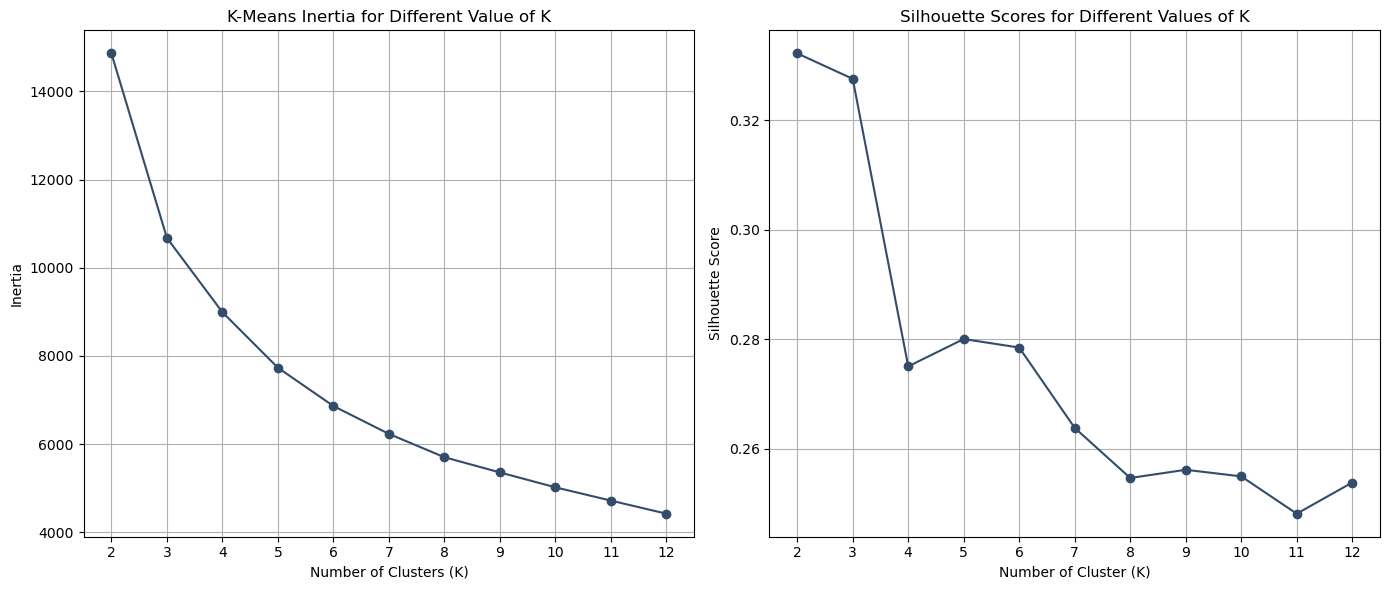

In [118]:
# Initialize the K-Means clustering model for the outlier clusters

max_k = 12

inertia = []
silhouette_scores = []
k_values = range(2, max_k+1)

for k in k_values:
    
    kmeans = KMeans(n_clusters=k, random_state=42, max_iter=1000)
    cluster_labels = kmeans.fit_predict(scaled_data_df)
    sil_score = silhouette_score(scaled_data_df, cluster_labels)
    silhouette_scores.append(sil_score)
    kmeans.fit_predict(scaled_data_df)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(14,6))

plt.subplot(1, 2, 1)
plt.plot(k_values, inertia, marker='o', color='#334c69')
plt.title('K-Means Inertia for Different Value of K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.xticks(k_values)
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(k_values, silhouette_scores, marker='o', color='#334c69')
plt.title('Silhouette Scores for Different Values of K')
plt.xlabel('Number of Cluster (K)')
plt.ylabel('Silhouette Score')
plt.xticks(k_values)
plt.grid(True)

plt.tight_layout()
plt.show()

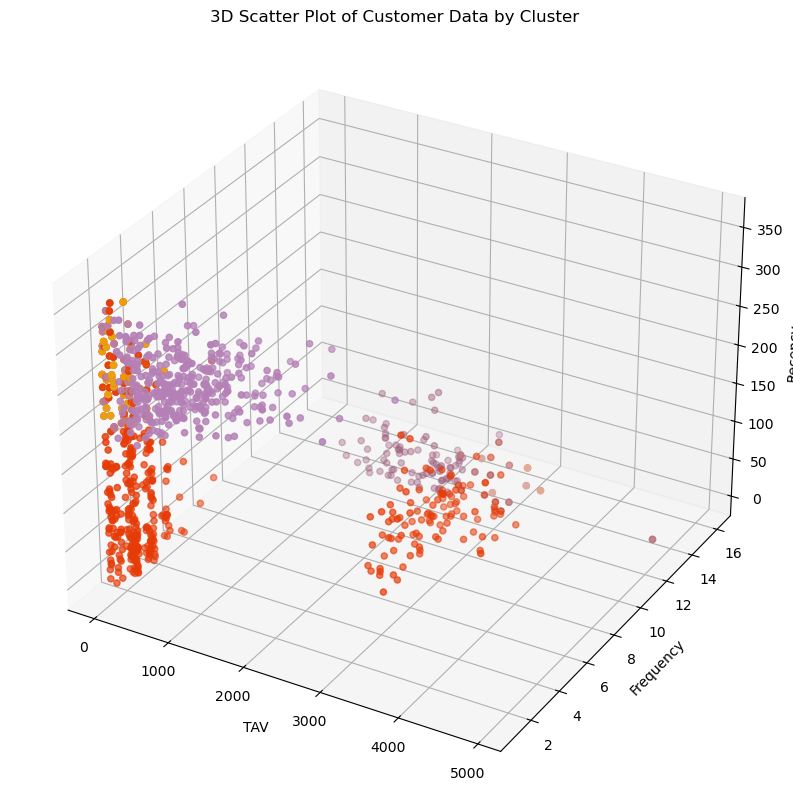

In [120]:
# Plot the outlier clusters

cluster_colors = {-1: '#e63b07',
                  -2: '#9d5c7b',
                  -3: '#b480b6',
                  -4: '#f2e1c9',
                  -5: '#f0a500'}

colors = outlier_clusters_df['Cluster'].map(cluster_colors)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')

scatter = ax.scatter(outlier_clusters_df['TAV'],
                     outlier_clusters_df['Frequency'],
                     outlier_clusters_df['Recency'],
                     c=colors,
                     marker='o')

ax.set_xlabel('TAV')
ax.set_ylabel('Frequency')
ax.set_zlabel('Recency')

ax.set_title('3D Scatter Plot of Customer Data by Cluster')

plt.show()

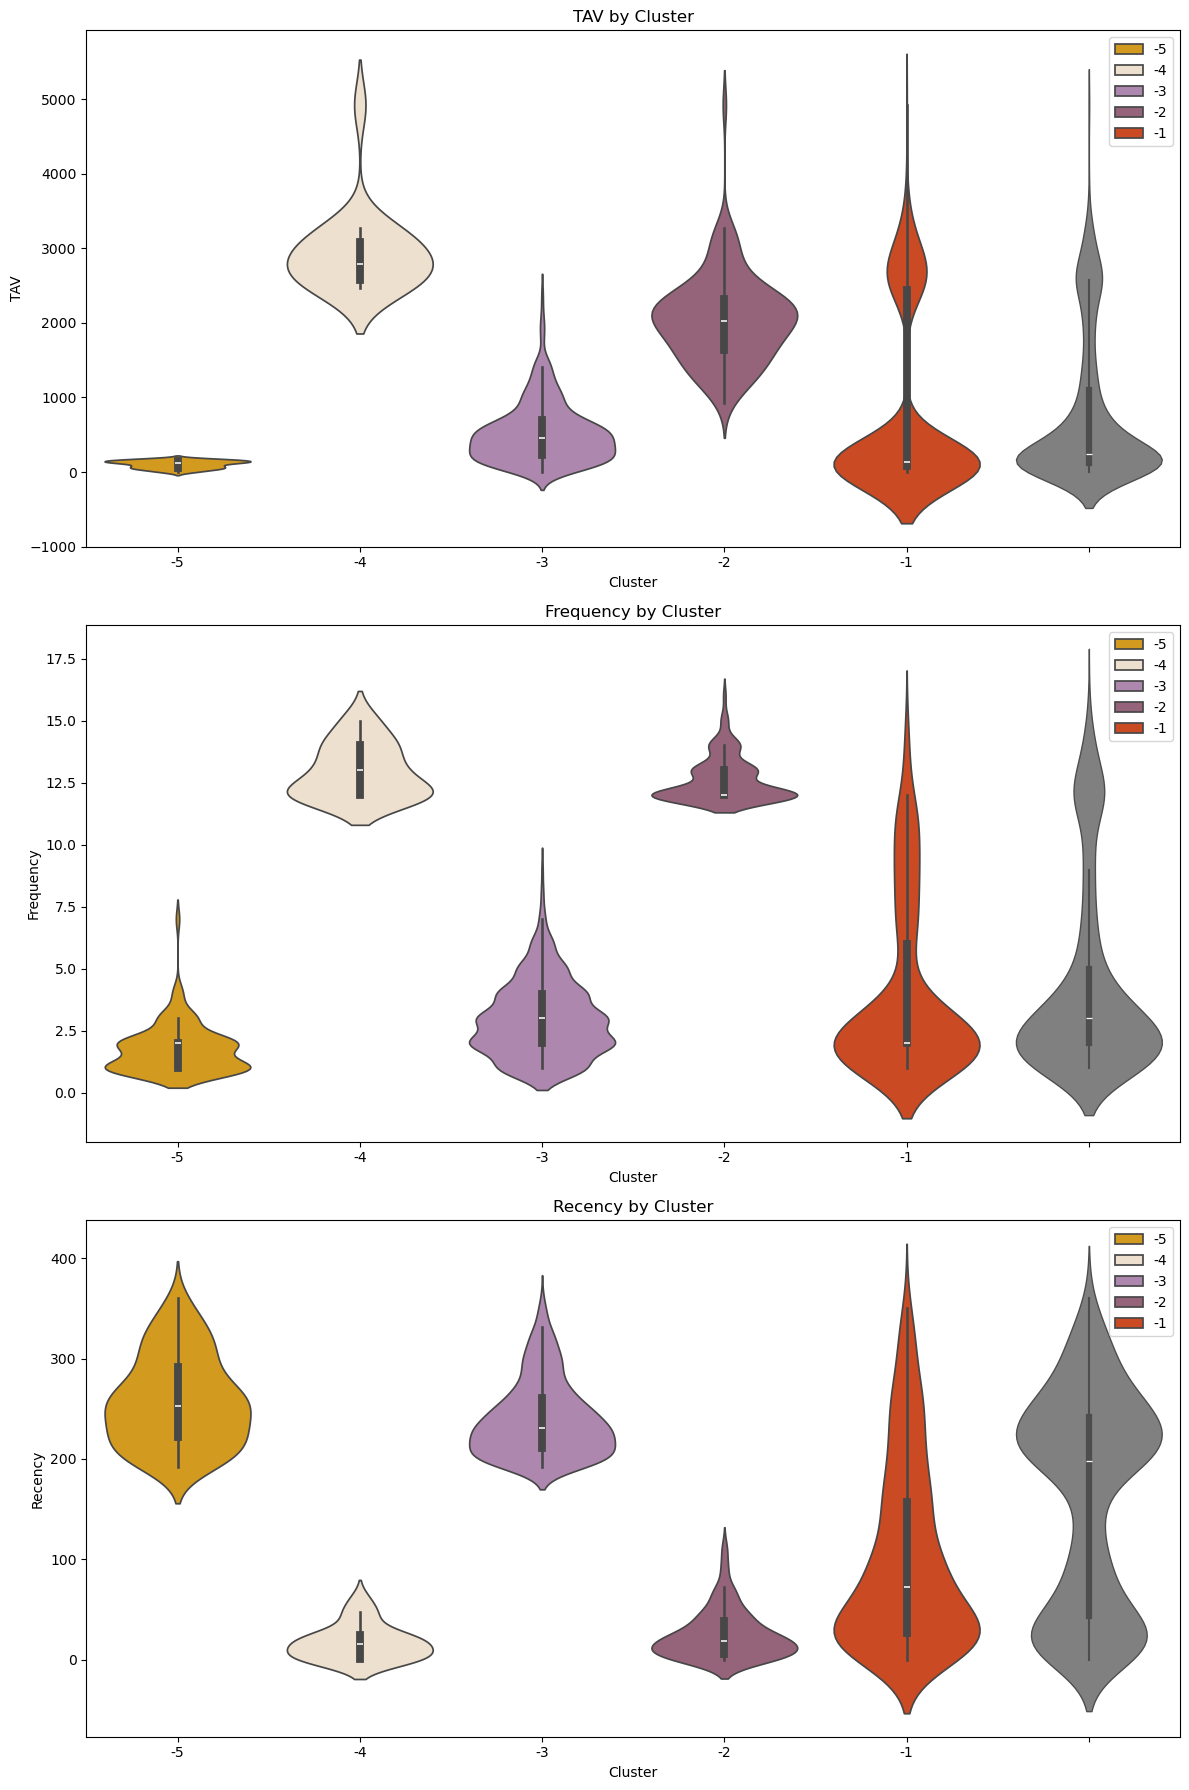

In [53]:
# Plot outlier clusters to compare across each of the three features

cluster_colors = {-1: '#e63b07',
                  -2: '#9d5c7b',
                  -3: '#b480b6',
                  -4: '#f2e1c9',
                  -5: '#f0a500'}

plt.figure(figsize=(12, 18))

plt.subplot(3, 1, 1)
sns.violinplot(x=outlier_clusters_df['Cluster'], y=outlier_clusters_df['TAV'], palette=cluster_colors, hue=outlier_clusters_df["Cluster"])
sns.violinplot(y=outlier_clusters_df['TAV'], color='gray',linewidth=1.0)
plt.title('TAV by Cluster')
plt.ylabel('TAV')

plt.subplot(3, 1, 2)
sns.violinplot(x=outlier_clusters_df['Cluster'], y=outlier_clusters_df['Frequency'], palette=cluster_colors, hue=outlier_clusters_df["Cluster"])
sns.violinplot(y=outlier_clusters_df['Frequency'], color='gray',linewidth=1.0)
plt.title('Frequency by Cluster')
plt.ylabel('Frequency')

plt.subplot(3, 1, 3)
sns.violinplot(x=outlier_clusters_df['Cluster'], y=outlier_clusters_df['Recency'], palette=cluster_colors, hue=outlier_clusters_df["Cluster"])
sns.violinplot(y=outlier_clusters_df['Recency'], color='gray',linewidth=1.0)
plt.title('Recency by Cluster')
plt.ylabel('Recency')

plt.tight_layout()
plt.show()

# 6. Cluster Development

In [55]:
# Label clusters based on features
# Re-label clusters that have close feature characteristics to reduce cluster count exclusive to outliers

cluster_labels = {
    0: "ENCOURAGE",
    1: "UPSELL",
    2: "RETAIN",
    3: "EXCITE",
    -1: "EXCITE",
    -2: "REWARD",
    -3: "RE-ENGAGE",
    -4: "REWARD",
    -5: "RE-ENGAGE"
}

In [56]:
# Combine non-outlier and outlier datasets

full_clustering_df = pd.concat([non_outliers_df, outlier_clusters_df])

full_clustering_df

,CustomerID,TAV,Frequency,LastInvoiceDate,Recency,Cluster
0,cust1000,1840.87,9,2024-10-27,1,1
1,cust1001,1009.89,6,2024-09-16,42,2
2,cust1002,782.89,5,2024-09-15,43,0
3,cust1003,574.49,5,2024-09-06,52,0
4,cust1004,265.55,4,2024-09-29,29,0
...,...,...,...,...,...,...
8520,cust9545,152.09,2,2024-03-19,223,-5
8625,cust9650,162.50,2,2024-02-22,249,-5
8695,cust9720,49.65,1,2024-02-04,267,-5
8724,cust9749,149.84,3,2024-02-17,254,-5


In [57]:
# Add Cluster Label column

full_clustering_df["Cluster Label"] = full_clustering_df["Cluster"].map(cluster_labels)

full_clustering_df

,CustomerID,TAV,Frequency,LastInvoiceDate,Recency,Cluster,Cluster Label
0,cust1000,1840.87,9,2024-10-27,1,1,UPSELL
1,cust1001,1009.89,6,2024-09-16,42,2,RETAIN
2,cust1002,782.89,5,2024-09-15,43,0,ENCOURAGE
3,cust1003,574.49,5,2024-09-06,52,0,ENCOURAGE
4,cust1004,265.55,4,2024-09-29,29,0,ENCOURAGE
...,...,...,...,...,...,...,...
8520,cust9545,152.09,2,2024-03-19,223,-5,RE-ENGAGE
8625,cust9650,162.50,2,2024-02-22,249,-5,RE-ENGAGE
8695,cust9720,49.65,1,2024-02-04,267,-5,RE-ENGAGE
8724,cust9749,149.84,3,2024-02-17,254,-5,RE-ENGAGE


In [58]:
# Set colors for plotting clusters as combined bar and line graph

custom_palette_bars = ['#e63b07', '#9d5c7b', '#b480b6', '#d1a1d7', '#f2e1c9', '#f0a500']
custom_palette_lines = ['#334c69', '#4b786f','#73a073']

C:\Users\halli\AppData\Local\Temp\ipykernel_13940\3033972614.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_counts.index, y=cluster_counts.values, ax=ax1, palette=custom_palette_bars)


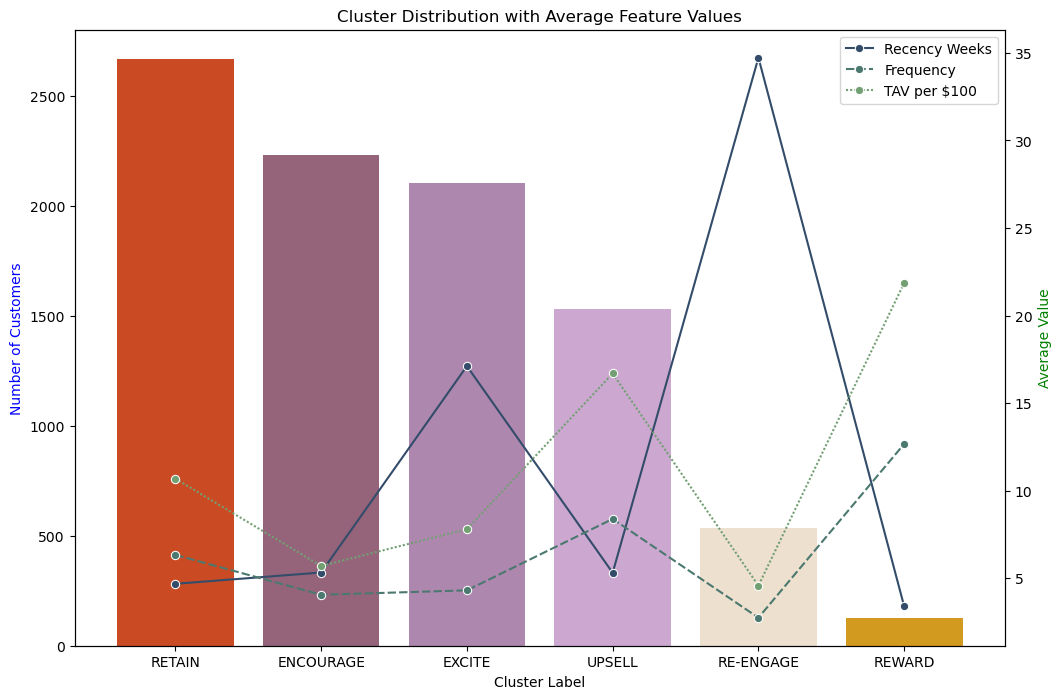

In [59]:
# Plot a combined bar and line graph to compare clusters and their feature characteristics

cluster_counts = full_clustering_df['Cluster Label'].value_counts()
full_clustering_df["TAV per $100"] = full_clustering_df["TAV"] / 100.00
full_clustering_df["Recency Weeks"] = full_clustering_df["Recency"] / 7
feature_means = full_clustering_df.groupby('Cluster Label')[['Recency Weeks','Frequency','TAV per $100']].mean()

fig, ax1  = plt.subplots(figsize=(12, 8))

sns.barplot(x=cluster_counts.index, y=cluster_counts.values, ax=ax1, palette=custom_palette_bars)
ax1.set_ylabel('Number of Customers', color='b')
ax1.set_title('Cluster Distribution with Average Feature Values')

ax2 = ax1.twinx()

sns.lineplot(data=feature_means, ax=ax2, palette = custom_palette_lines, marker='o')
ax2.set_ylabel('Average Value', color='g')

plt.show()

In [60]:
# Print feature value averages for each cluster

print(feature_means)

               Recency Weeks  Frequency  TAV per $100
Cluster Label                                        
ENCOURAGE           5.335637   4.064068      5.710276
EXCITE             17.120179   4.317966      7.808785
RE-ENGAGE          34.725725   2.754190      4.585320
RETAIN              4.689637   6.340210     10.694480
REWARD              3.400922  12.677419     21.866534
UPSELL              5.321359   8.392554     16.697715


In [61]:
# Display the first 10 rows of the final dataset

full_clustering_df.head(10)

,CustomerID,TAV,Frequency,LastInvoiceDate,Recency,Cluster,Cluster Label,TAV per $100,Recency Weeks
0,cust1000,1840.87,9,2024-10-27,1,1,UPSELL,18.4087,0.142857
1,cust1001,1009.89,6,2024-09-16,42,2,RETAIN,10.0989,6.000000
2,cust1002,782.89,5,2024-09-15,43,0,ENCOURAGE,7.8289,6.142857
3,cust1003,574.49,5,2024-09-06,52,0,ENCOURAGE,5.7449,7.428571
4,cust1004,265.55,4,2024-09-29,29,0,ENCOURAGE,2.6555,4.142857
5,cust1005,1254.24,10,2024-09-21,37,1,UPSELL,12.5424,5.285714
6,cust1006,1295.17,7,2024-09-15,43,2,RETAIN,12.9517,6.142857
7,cust1007,485.42,3,2024-08-26,63,0,ENCOURAGE,4.8542,9.000000
8,cust1008,1101.60,5,2024-10-14,14,2,RETAIN,11.0160,2.000000
9,cust1009,1111.69,6,2024-10-12,16,2,RETAIN,11.1169,2.285714


In [122]:
# Show average annaul spend for customers within each cluster

full_clustering_df['OrderTotal'] = full_clustering_df['TAV'] / full_clustering_df['Frequency']
order_totals = full_clustering_df.groupby(['CustomerID','Cluster Label'])['OrderTotal'].sum().reset_index()
customer_label_avg = order_totals.groupby('Cluster Label')['OrderTotal'].mean().reset_index()

customer_label_avg.columns = ['Cluster Label', 'Average Spend']

print(customer_label_avg)

  Cluster Label  Average Spend
0     ENCOURAGE     152.149942
1        EXCITE     170.914714
2     RE-ENGAGE     200.742992
3        RETAIN     179.043724
4        REWARD     203.840157
5        UPSELL     208.458389


# Summary and Next Steps

### Cluster Summaries

1. RETAIN: These customers have made relatively recent purchases, with a moderate frequency of purchase, and they have a high annual spend. They're consistent spenders with a potential for long-term loyalty.
   Recommendation: Encourage continued engagement by offering loyalty rewards.
   
2. ENCOURAGE: Customers in this segment have made recent purchases but at a low frequency and with a low annual spend. They may still be exploring the brand or need a nudge to purchase more regularly.
   Recommendation: Incentivize their next purchase by offering a discount for a limited-time period.
   
3. EXCITE: These customers haven't purchased recently, shop infrequently, and have a moderate annual spend. They may need a renewed reason to engage with the brand.
   Recommendation: Use urgency-based incentives, like flash sales, to prompt re-engagement.
   
4. UPSELL: These customers have made recent purchases at a moderate frequency and demonstrate high annual spending. They're engaged but could be encouraged to spend more per transaction.
   Recommendation: Suggest complementary or premium products to increase their order value. Offer add-ons or subscriptions to enhance their purchase  value and frequency.
   
5. RE-ENGAGE: This segment consists of customers who made purchases a long time ago, with low frequency and low annual spend. They may be at risk of churn and need a reason to return.
   Recommendation: Communicate during key events when they may be more likely to re-engage through an additional purchase.
   
6. REWARD: These customers are the most engaged, with very recent and frequent purchases and the highest annual spend. They represent the brand's most valuable and loyal customers.
   Recommendation: Encourage referrals, even offering referral bonuses or rewards. Elevate their brand experience with exclusive access or events.

### Next Steps

There are several opportunities for further utilizing these insihgts, optimizing strategies and enhancing operational capabilities. A few of these may include:

- Implement real-time segmentation to dynamically shift persoonalized marketing and communications.
- Build a churn prediction model, particularly focused on "RE-ENGAGE" and "EXCITE" clusters.
- Estimate Customer Lifetime Value (CLV) for each cluster to efficiently allocate resources for long-term strategies.
- Use A/B testing or multi-variate testing to gather performance based on each segment and refine marketing strategies accordingly.
  